# Diffusion Maps as dimensionality reduction to study stability of blockings

## Outline:
1. Get data
2. Prepare data
3. Explore data
4. Perform nearest neighbor search
5. Assemble diffusion matrix
6. Apply eigenvalue decomposition
7. Use diffusion map representation to study stability

## Data
- For the Euro-Atlantic sector (20-90 N; 110-0W)
- Calculate gh500 daily anomalies:
    - calulate daily mean gh500 values gridpoint wise
    - subtract mean from daily values
- Remove the seasonal cycle of the anomalies (larger in winter) by
    - calculating sd of anomalies at each grid point and day
    - dividing the time series of anomalies by that sd
- Calculate EOFs (maybe 50)
- Obtain time series of PCs

All done using CDOs and shellscripts

### Should data be low-pass filtered first? Should the daily mean be exchanged for a running mean? Same for anomaly normalization?

### Does the data have a trend?

In [1]:
import sys, os, importlib
sys.path.append(os.path.abspath(os.path.join('..', 'pyscripts')))

import data_classes
import utils as ut
importlib.reload(data_classes)
importlib.reload(ut)

from data_classes import DataHandler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import scipy.sparse as sps
from scipy.integrate import solve_ivp
import matplotlib.cm as cm

plt.rcParams['text.usetex'] = True
plt.rcParams['pgf.texsystem'] = "pdflatex"
plt.rcParams['text.latex.preamble'] = (
    r'\usepackage{amsmath,amsfonts,amssymb,cmbright,standalone}')

In [2]:
f_path = "/net/scratch/schoelleh96/WP2/WP2.2a/data/"
n = 50 # number of eofs
anos = DataHandler(f_path + "anos.nc")
anos.load_data()
EOFs = DataHandler(f_path + "evecs.nc")
EOFs.load_data()
Evals = DataHandler(f_path + "evals.nc")
Evals.load_data()
PCs = DataHandler(f_path + "pcs.nc")
PCs.load_data()

/home/schoelleh96/mambaforge/envs/wp22a/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/schoelleh96/mambaforge/envs/wp22a/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/home/schoelleh96/mambaforge/envs/wp22a/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/schoelle

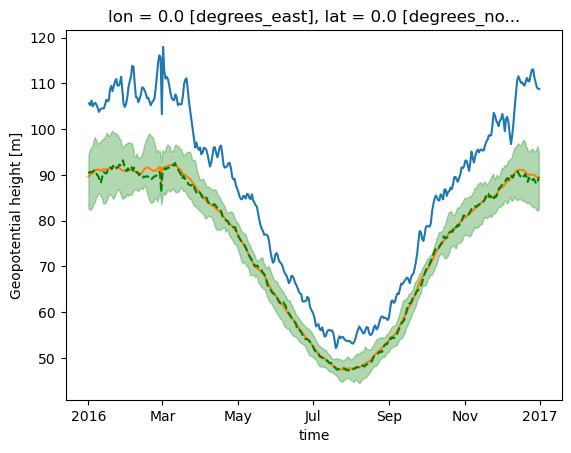

In [35]:
import xarray as xr
# anosdetrend > ydaystd > fldmean
data = xr.open_dataset("../data/stddetrendmean.nc")
time = pd.to_datetime(data['time'].values)
# Replace the year with 2016 for all dates
new_time = time.map(lambda t: t.replace(year=2016))
# Assign the new time values back to the dataset
data['time'] = new_time

data["zg"].isel(lat=0, lon=0).plot.line()

# anosdetrend > runstd,30 > fldmean > ydaymean
data = xr.open_dataset("../data/stddetrend30ymean.nc")
time = pd.to_datetime(data['time'].values)
# Replace the year with 2016 for all dates
new_time = time.map(lambda t: t.replace(year=2016))
# Assign the new time values back to the dataset
data['time'] = new_time

data["zg"].isel(lat=0, lon=0).plot.line()

# anosdetrend > runstd,30 > fldmean
data = xr.open_dataset("../data/stddetrend30mean.nc")
# Assuming "zg" is the variable of interest
# Replace the year with 2016 for all dates
time = pd.to_datetime(data['time'].values)
new_time = time.map(lambda t: t.replace(year=2016))
data['time'] = new_time

day_of_year = data['time'].dt.dayofyear  # Extract the day of the year

median_values = data["zg"].isel(lat=0, lon=0).groupby(day_of_year).median(dim='time')
q1_values = data["zg"].isel(lat=0, lon=0).groupby(day_of_year).quantile(0.25, dim='time')
q3_values = data["zg"].isel(lat=0, lon=0).groupby(day_of_year).quantile(0.75, dim='time')


# Plot median
plt.plot(np.unique(new_time), median_values, label='Median', color='green', linestyle='--')

# Fill between Q1 and Q3 for quartiles
plt.fill_between(np.unique(new_time), q1_values, q3_values, color='green', alpha=0.3, label='IQR (Q1-Q3)')

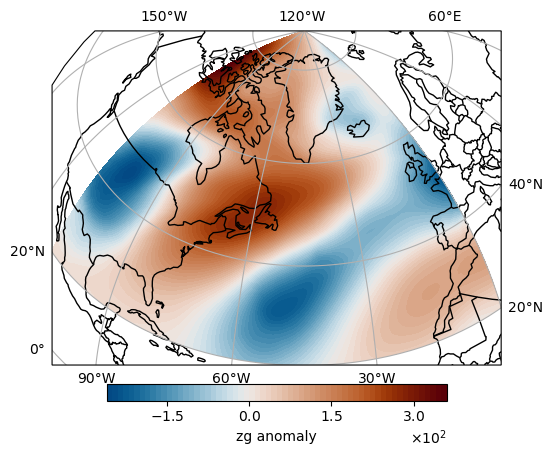

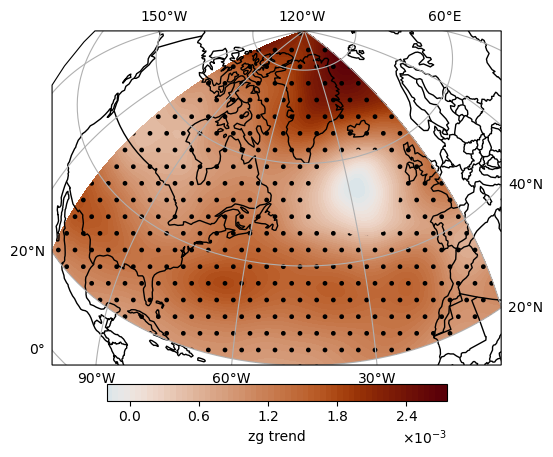

In [2]:
anos.plot_data("zg", 0, "zg anomaly")
anos.calc_trend("zg")
anos.plot_trend("zg", "zg trend")

**Yes it does! The calculation of the EOFs used detrended data.**

### A look at the EOFs and PCs:

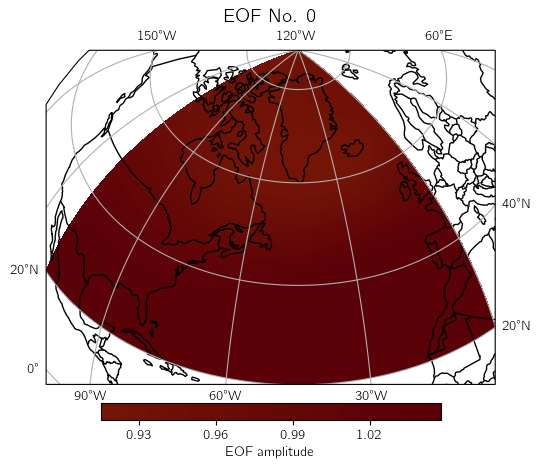

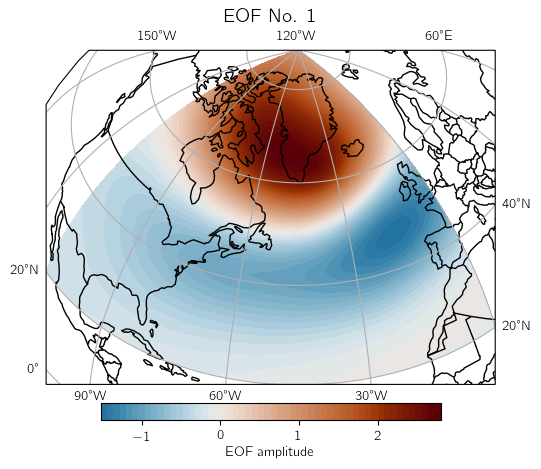

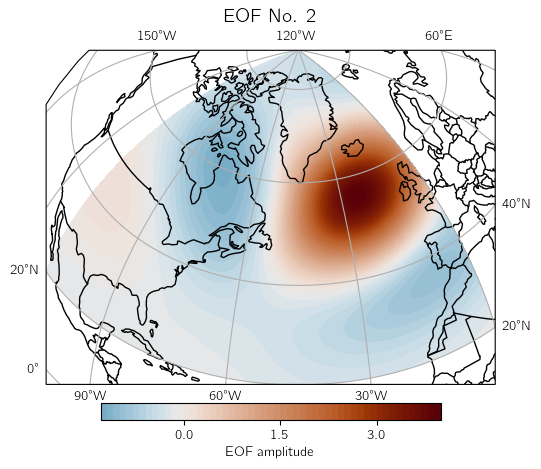

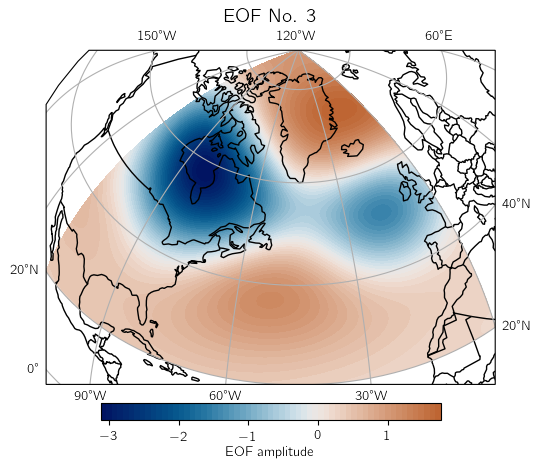

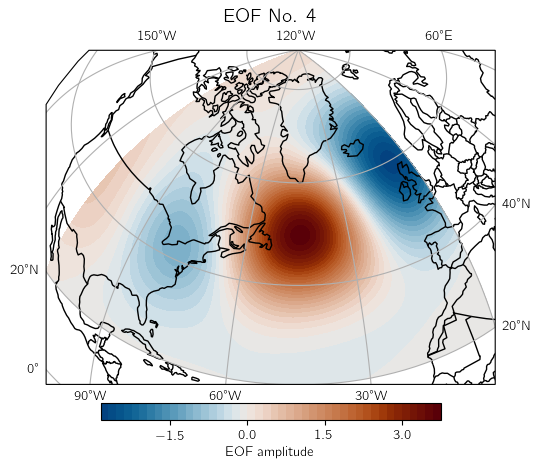

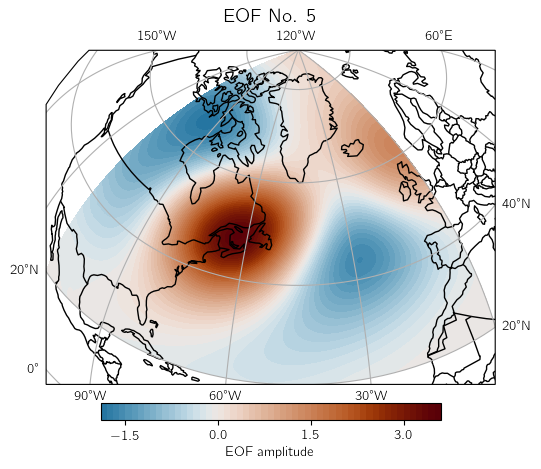

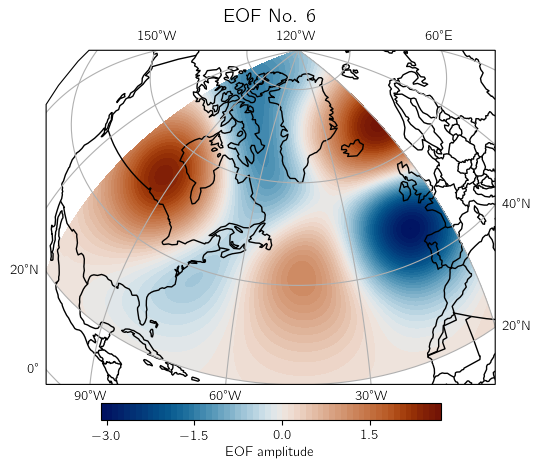

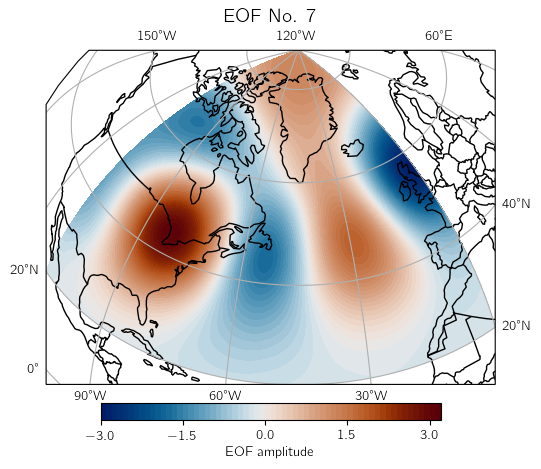

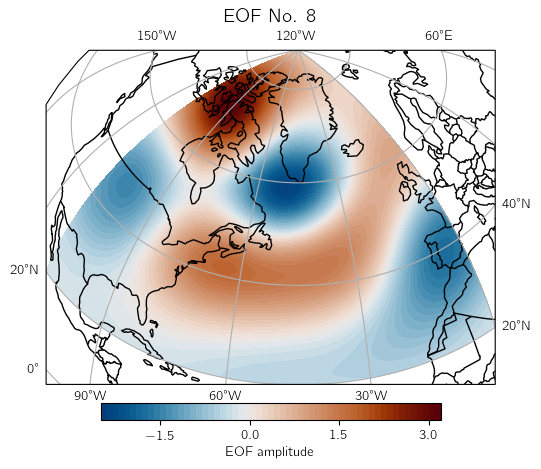

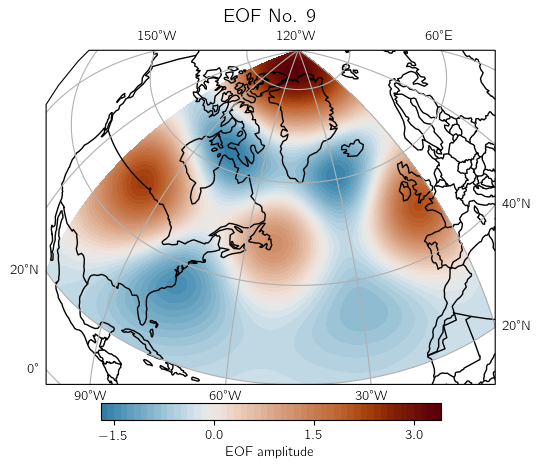

In [3]:
for i in range(10):
    EOFs.plot_data("zg", i, "EOF amplitude", "EOF No. {}".format(i))

In [6]:
pc_std = []
for i in range(50):
    pc_std.append(PCs.dataset["zg"][:,i,:,:].std())
pc_std.sort(reverse=True)
pc_std = np.array(pc_std)**2
pc_std = pc_std / pc_std.sum() * Evals.dataset["zg"].values.flatten().sum()


In [7]:
pc_std.sum()

np.float32(38.112316)

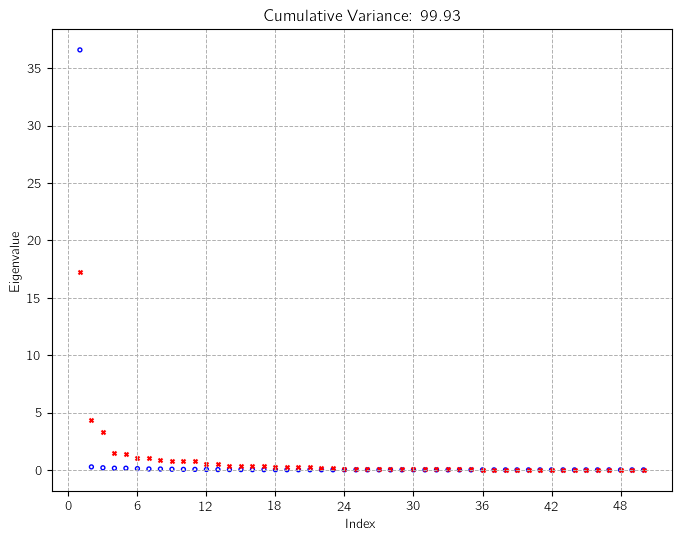

In [8]:
var_ratio = Evals.dataset["zg"].values.flatten()[:n].sum()/Evals.dataset["zg"].values.flatten().sum() * 100
# plot more eigenvalues
# Plot the first 10 eigenvalues (for example)
ax = Evals.plot_1d("zg", "Index", "Eigenvalue", n=n, title="Cumulative Variance: {:.2f} %".format(var_ratio))
ax.scatter(np.arange(1, 51), pc_std, marker="x", color="red", s=8)
plt.show()

In [2]:
# Make sure to scale the PCs by their respective eigenvalue to get unit variance
n_pcs = PCs.dataset["zg"].shape[1]
# Reshape eigenvalues to match the shape of PCs along the respective dimensions
reshaped_evals = np.sqrt(Evals.dataset["zg"].values.flatten()[:n_pcs]).reshape(1, n_pcs, 1, 1)

# Now divide the PCs by the reshaped eigenvalues
PCs.dataset["zg"].values = PCs.dataset["zg"].values / reshaped_evals

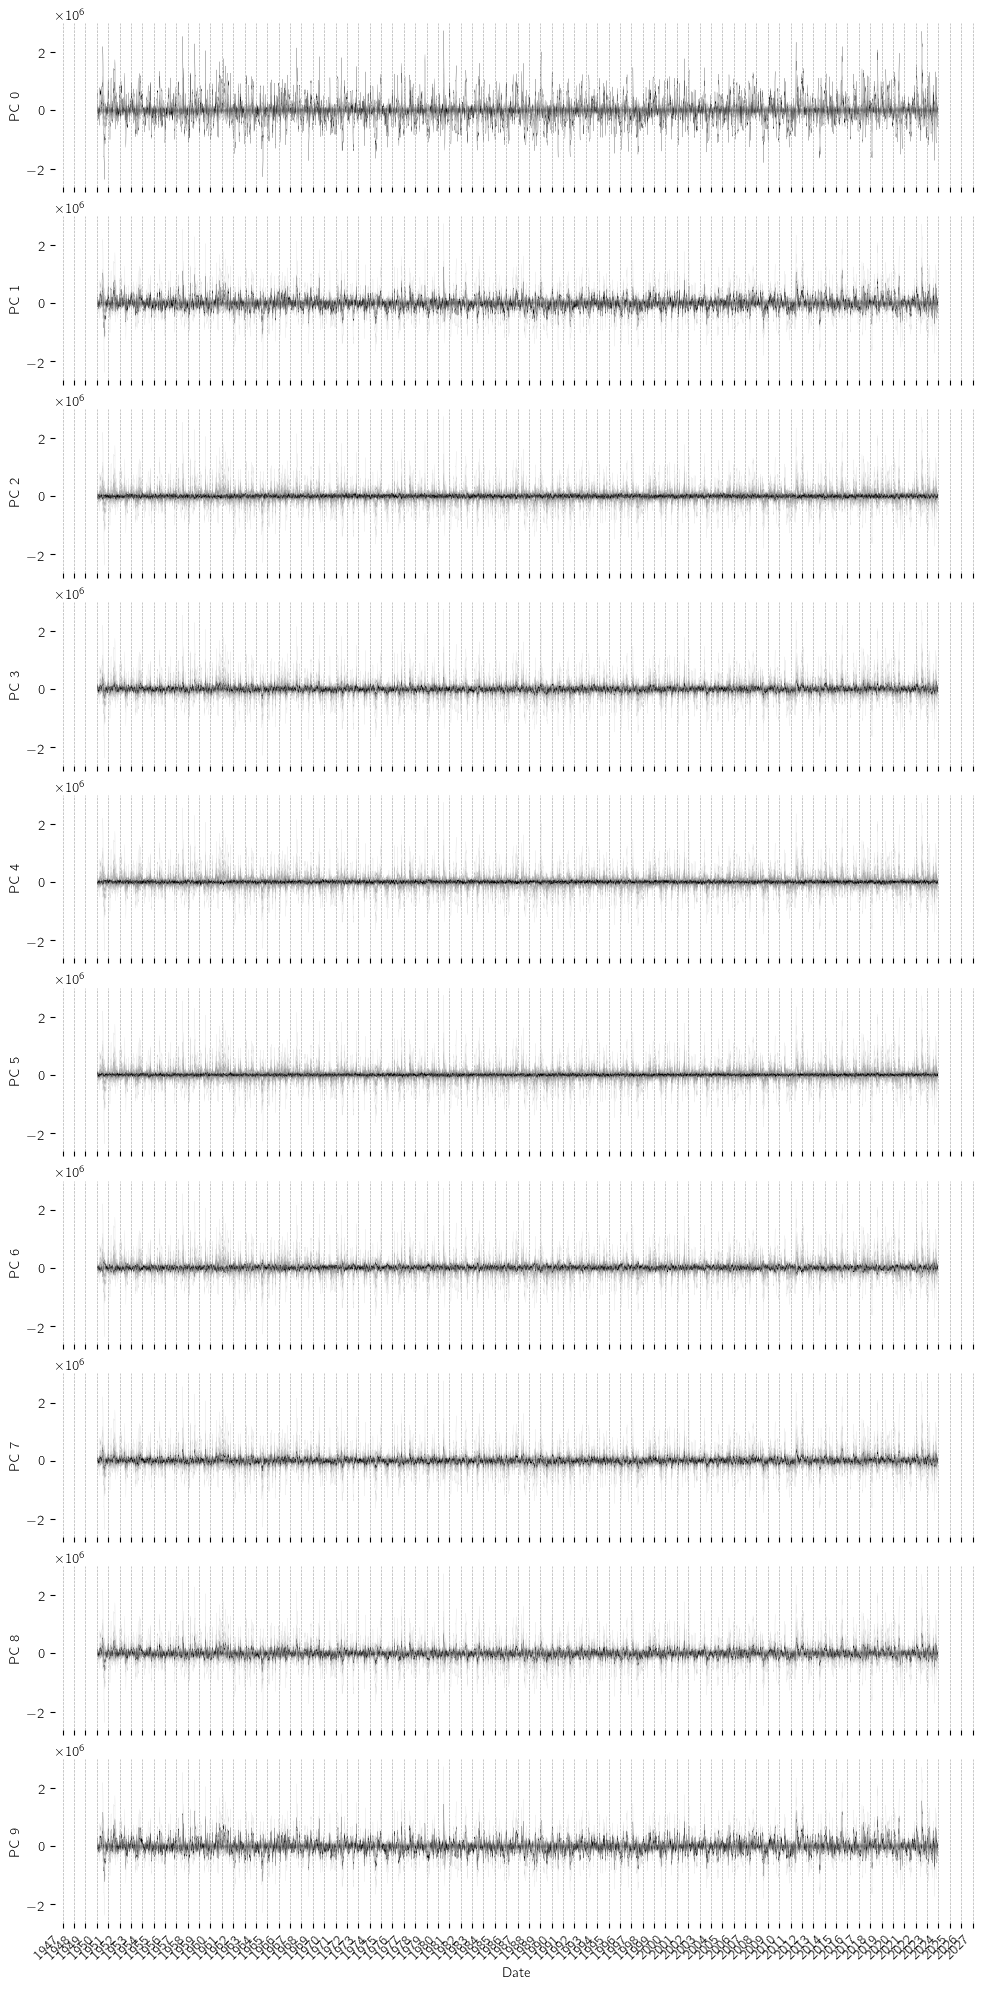

In [9]:
# Plot the first n PCs (for example)
PCs.plot_stacked_lines("zg", ylabel="PC {}", n=10)

### How does the data look in EOF space?

In [13]:
data = PCs.dataset["zg"].values
df = pd.DataFrame(data.reshape(data.shape[0], -1), columns=[f'PC_{i}' for i in range(data.shape[1])])


In [ ]:
sns.pairplot(df, kind='kde')


### Point Cloud in EOF space with colors according to whether block or not

In [40]:
block_path = "/net/scratch/schoelleh96/evaluation_system/output/blocking_2d/20240919_131749/27145/ibbi/r1i1p1-050000pa/"
block_df = pd.read_csv(block_path + "BR-properties_ifs_era5_r1i1p1-050000pa_19500101-20181231.csv", skiprows=24)
block_df['BR_date_start'] = pd.to_datetime(block_df['BR_date_start'], format='%Y%m%d')
block_df['BR_date_end'] = pd.to_datetime(block_df['BR_date_end'], format='%Y%m%d')

print(block_df)

      BR_number  BR_ID  BR_timestep_count BR_date_start  BR_time_start  \
0             1      1                  5    1950-01-06              0   
1             2      2                  4    1950-01-10              0   
2             3      3                  6    1950-01-12              0   
3             4      4                  6    1950-01-18              0   
4             5      5                  5    1950-01-19              0   
...         ...    ...                ...           ...            ...   
2996       2997   2997                  4    2018-12-17              0   
2997       2998   2998                  5    2018-12-20              0   
2998       2999   2999                  5    2018-12-20              0   
2999       3000   3000                  4    2018-12-28              0   
3000       3001   3001                  4    2018-12-28              0   

     BR_date_end  BR_time_end  BR_BG_count  BR_BSR_count  BR_zonalRange_W  \
0     1950-01-10            0     

In [41]:
# create a date range DataFrame
date_range = pd.Series(pd.date_range("16/01/1950", "17/12/2018"), name="date")
# merge the original DataFrame with the date range DataFrame
merged_df = pd.merge_asof(date_range, block_df, left_on='date', right_on='BR_date_start', direction='nearest')
# create a boolean mask where the event is True
event_series = (merged_df['date'].between(merged_df['BR_date_start'], merged_df['BR_date_end'], inclusive='both')) & (merged_df['BR_timestep_count'] >= 5)

# reset the index to get a Series with the same length as the date range
event_series = event_series.reset_index(drop=True)

In [42]:
df["blocked"] = event_series
#sns.pairplot(df, kind='kde', hue="blocked") #  normalize both curves in the diagonal

# Quick and dirty FTLEs

## Linearly approximate FTLEs at each point in time

In [11]:
def estimateJacobianCentralDiff(pcs, dt):
    """
    Estimate the Jacobian at each time step using central differences in
    the reduced PC space.

    Parameters:
        pcs (ndarray): Array of shape (T, N), where T is the number of time
                       steps, and N is the reduced dimension (number of EOF modes).
                       Each row represents the PCs at a given time step.
        dt (float): Time step interval.

    Returns:
        jacobians (ndarray): Array of shape (T, N, N) containing the Jacobian
                             at each time step in the reduced PC space.
    """
    T, N = pcs.shape
    jacobians = np.zeros((T, N, N))  # Initialize array to store Jacobians for each time step

    # Calculate central differences for each interior time point
    for t in range(1, T - 1):
        for i in range(N):
            for j in range(N):
                # Central difference: (y_j(t + dt) - y_j(t - dt)) / (2 * dt)
                jacobians[t, i, j] = (pcs[t + 1, j] - pcs[t - 1, j]) / (2 * dt)

    # Handle boundary points (optional): Forward/backward differences if needed
    for i in range(N):
        for j in range(N):
            # Forward difference for first time step
            jacobians[0, i, j] = (pcs[1, j] - pcs[0, j]) / dt
            # Backward difference for last time step
            jacobians[T - 1, i, j] = (pcs[T - 1, j] - pcs[T - 2, j]) / dt

    return jacobians


In [46]:
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression

def estimateNonLocalJacobian(pcs, dt, n_neighbors=10, k=2):
    """
    Estimate the Jacobian at each time step using local linear regression
    on nearest neighbors in EOF space and considering temporal evolution.

    Parameters:
        pcs (ndarray): Array of shape (T, N), where T is the number of time
                       steps and N is the reduced dimension (number of EOF modes).
                       Each row represents the PCs at a given time step.
        dt (float): Time step interval.
        n_neighbors (int): Number of nearest neighbors in EOF space to use
                           for local regression at each time step.
        k (int): Number of previous and next time steps to consider for 
                  each neighbor.

    Returns:
        jacobians (ndarray): Array of shape (T, N, N) containing the Jacobian
                             at each time step in the reduced PC space.
    """
    T, N = pcs.shape
    jacobians = np.zeros((T, N, N))  # Array to store Jacobians for each time step
    
    # Initialize the NearestNeighbors model to find nearest neighbors in PC space
    nn_model = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm='auto')
    nn_model.fit(pcs)  # Fit to the entire dataset of PCs
    
    # Estimate the Jacobian for each time point based on its nearest neighbors
    for t in range(T):
        print(t)
        # Find the nearest neighbors (including the point itself)
        distances, indices = nn_model.kneighbors([pcs[t]], n_neighbors=n_neighbors + 1)
        indices = indices.flatten()[1:]  # Exclude the point itself from its neighbors

        # Prepare arrays for collecting regression data
        X, Y = [], []

        # Iterate over each neighbor
        for neighbor_index in indices:
            # Collect data for the current neighbor
            for dt_offset in range(-k, k + 1):  # k previous and k next steps
                neighbor_time = neighbor_index + dt_offset
                if 0 <= neighbor_time < T:  # Check bounds
                    X.append(pcs[neighbor_time])
                    Y.append(pcs[neighbor_time + 1] if neighbor_time + 1 < T else pcs[neighbor_time])
        
        # Convert to numpy arrays for regression
        X = np.array(X)
        Y = np.array(Y)

        # Perform linear regression to estimate the Jacobian
        model = LinearRegression(fit_intercept=False)
        model.fit(X, Y)
        
        # Store the fitted coefficients as the Jacobian at time step t
        jacobians[t, :, :] = model.coef_

    return jacobians


In [15]:
data.shape

(26999, 50, 1, 1)

In [47]:
jacobians = estimateJacobianCentralDiff(data[:,:,0,0], 1)

KeyboardInterrupt: 

In [146]:
jacobians = estimateNonLocalJacobian(data[:,:,0,0], 1, n_neighbors=5, k=3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [49]:
def calculateFTLEs(jacobians, dt):
    """
    Calculate the Finite-Time Lyapunov Exponents (FTLEs) from the Jacobian
    matrices obtained through linear regression or other methods.

    Parameters:
        jacobians (ndarray): Array of shape (T, N, N) containing the Jacobian
                             at each time step in the reduced PC space.
        dt (float): Time step interval.

    Returns:
        ftles (ndarray): Array of shape (T, N) containing the FTLEs for each time
                         step and each EOF mode.
    """
    T, N, _ = jacobians.shape
    ftles = np.zeros((T, N))  # Array to store FTLEs for each time step and EOF mode

    for t in range(T):
        print(t)
        # Perform Singular Value Decomposition on the Jacobian at time t
        U, s, Vt = np.linalg.svd(jacobians[t], full_matrices=False)
        
        # Calculate FTLE
        ftles[t, :] = (1 / dt) * np.log(s)  # Broadcast for all EOF modes

    return ftles


In [147]:
ftles = calculateFTLEs(jacobians, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [122]:
ftles[::100,1]

array([1.4330579 , 1.35905597, 1.62125766, 2.23131725, 1.0233232 ,
       1.10186972, 1.07584144, 1.62318358, 1.52896343, 1.741043  ,
       1.58149033, 1.08522744, 1.6042732 , 1.36287694, 1.79378294,
       1.52518695, 1.68473484, 1.57568658, 1.32373589, 1.1583822 ,
       2.00417486, 1.4176877 , 1.93640828, 1.31584519, 1.08183689,
       1.51610897, 1.84235962, 1.7262536 , 0.75104613, 1.67809664,
       1.46590664, 1.25496888, 1.71360964, 1.74716216, 1.47469194,
       1.32181385, 1.35501634, 1.73299616, 1.91474584, 1.97483603,
       1.17699955, 1.0801602 , 1.43140144, 1.34757931, 1.77197308,
       0.88858649, 1.52846223, 1.20926037, 1.34076066, 1.42386783,
       1.39133225, 1.52294566, 1.48348267, 1.53093395, 1.45253409,
       0.77413108, 1.2554912 , 1.81480482, 1.12616419, 1.73459649,
       1.57122884, 1.28167316, 1.30693822, 2.11948818, 1.46472862,
       1.34191548, 0.97176882, 1.55571868, 1.07876997, 1.48916901,
       1.39118514, 1.23048711, 1.65595057, 1.54014964, 1.43072

<Axes: >

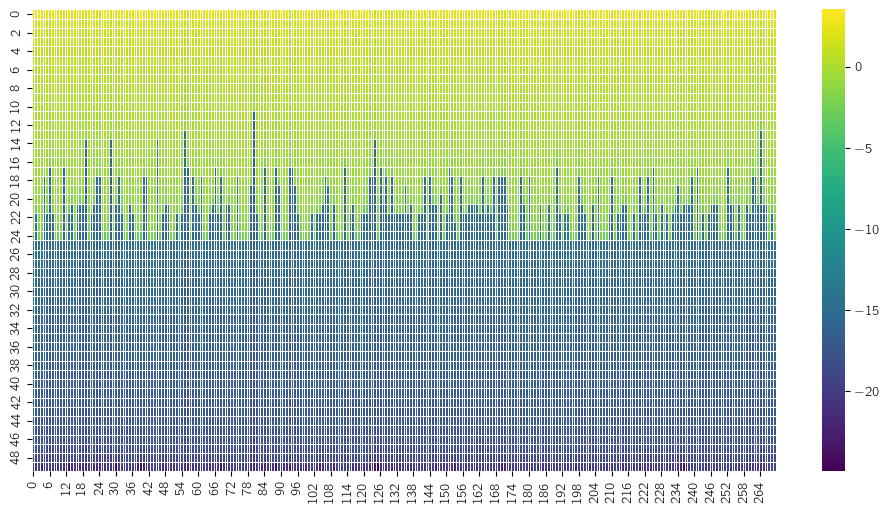

In [123]:
import seaborn as sns
plt.figure(figsize=(12, 6))  # Set the figure size
# Create a heatmap using seaborn
sns.heatmap(ftles[::100,:].T, cmap='viridis', cbar=True, linewidths=0.5)

In [54]:
ftles.shape
#df.shape

(26999, 50)

In [127]:
def calculateFiniteTimeKaplanYorkeDimension(ftles):
    """
    Calculate the finite-time Kaplan-Yorke dimension for each time step.
    Parameters:
        ftles (ndarray): Array of shape (T, N) containing FTLE values.

    Returns:
        ndarray: Array of finite-time Kaplan-Yorke dimensions for each time step.
    """
    T, N = ftles.shape
    kaplan_yorke_dims = np.zeros(T)  # Initialize array for results

    for t in range(T):
        # Calculate Lyapunov exponents for the current time step
        lyapunov_exponents = ftles[t,:] # Use FTLEs directly as Lyapunov exponents

        # Find the largest m such that the sum of the first m exponents is non-negative
        cumulative_sum = 0
        m = 0
        while m < lyapunov_exponents.shape[0] and cumulative_sum >= 0:
            cumulative_sum += lyapunov_exponents[m]
            m += 1

        # Calculate Kaplan-Yorke dimension for the current time step
        if m == 0:
            kaplan_yorke_dims[t] = 0.0
        else:
            if m < lyapunov_exponents.shape[0]:
                kaplan_yorke_dims[t] = (m - 1) + cumulative_sum / abs(lyapunov_exponents[m - 1])
            else:
                kaplan_yorke_dims[t] = m

    return kaplan_yorke_dims

def calculateFiniteTimeKolmogorovSinaiEntropy(ftles):
    """
    Calculate the finite-time Kolmogorov-Sinai entropy for each time step.

    Parameters:
        ftles (ndarray): Array of shape (T, N) containing FTLE values.

    Returns:
        ndarray: Array of finite-time KS entropies for each time step.
    """
    T, N = ftles.shape
    ks_entropies = np.zeros(T)  # Initialize array for results

    for t in range(T):
        lyapunov_exponents = ftles[t]  # Use FTLEs directly as Lyapunov exponents
        ks_entropies[t] = np.sum(lyapunov_exponents[lyapunov_exponents > 0])  # Sum of positive exponents

    return ks_entropies


In [148]:
df["ftle_1"] = ftles[:,0]

# Add new columns to the DataFrame
df['Dky'] = calculateFiniteTimeKaplanYorkeDimension(ftles)
df['Hks'] = calculateFiniteTimeKolmogorovSinaiEntropy(ftles)

In [137]:
def plotFTLEAndDimensions(dataframe):
    """
    Plot histograms of the largest FTLE, Kaplan-Yorke dimension,
    and Kolmogorov-Sinai entropy as KDEs in separate subplots using hue for 'blocked'.
    
    Parameters:
        dataframe (DataFrame): DataFrame containing FTLE, D_KY, H_KS, 
                               and "blocked" column.
    """
    # Set up subplots
    fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=False)

    # Plot each metric with KDE using hue for 'blocked'
    for i, col in enumerate(['ftle_1', 
                              'Dky', 
                              'Hks']):
        sns.kdeplot(data=dataframe, x=col, hue='blocked', ax=axs[i], 
                    fill=True, common_norm=False, alpha=0.5)

        axs[i].set_xlabel(f'{col}')  # Common x-label
        axs[i].set_ylabel('')
    axs[0].set_ylabel('Density')
    plt.tight_layout()


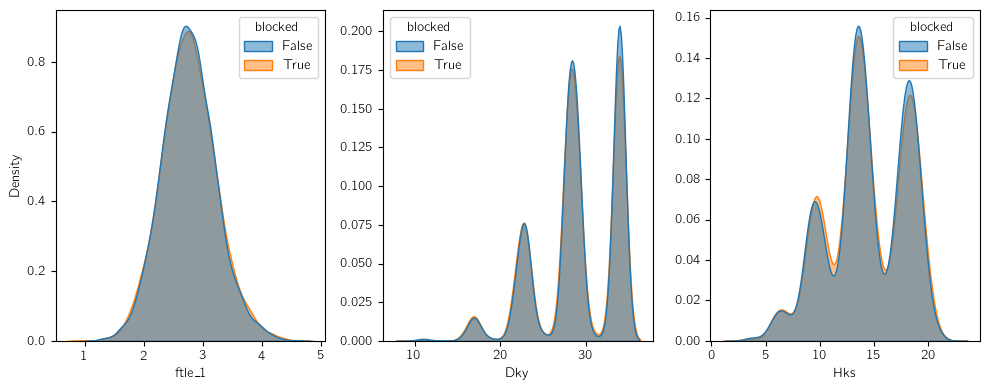

In [149]:
plotFTLEAndDimensions(df)
#plt.savefig("/home/schoelleh96/Nextcloud/SFB/24_SCCSdaysPoster/hists.pdf")

# Perform nearest neighbor search

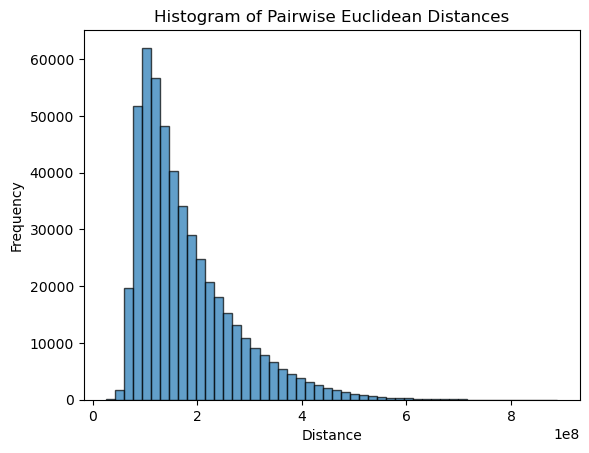

In [7]:
eps = 4 #  see below
ut.plot_distance_histogram(df.to_numpy()[:1000])

## Varying the cutoff radius reveals seasonal cycle in the density of states:

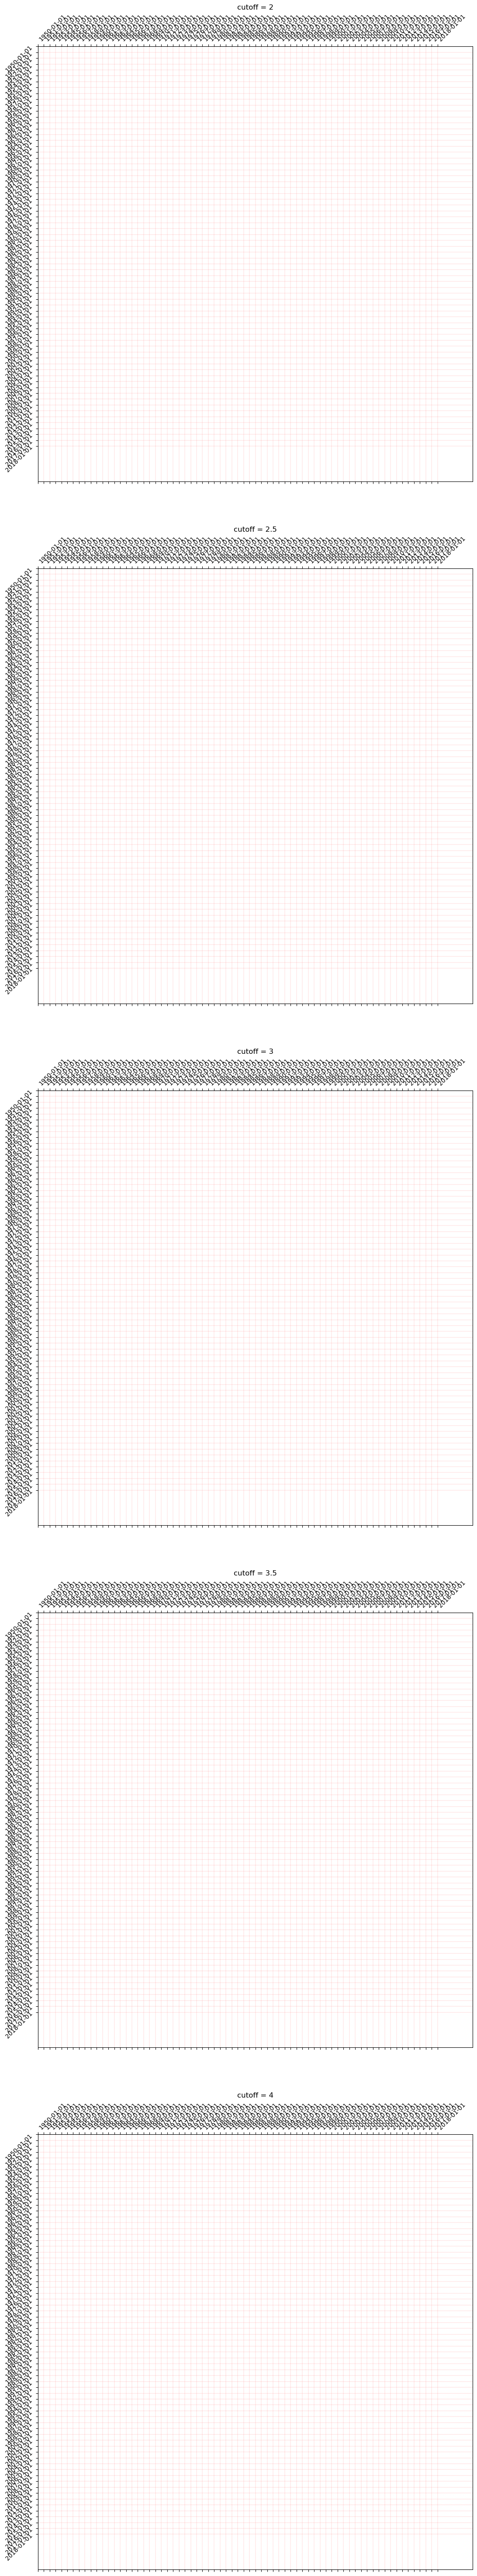

In [12]:
r_opt = [2,2.5,3,3.5,4]
fig, ax = plt.subplots(len(r_opt),1 ,figsize=(15, 15*len(r_opt)))

dates = pd.DatetimeIndex(date_range)
j1_dates = dates[(dates.day == 1) & (dates.month == 1)]

for i,r in enumerate(r_opt):
    D = ut.calculate_distances(df.to_numpy(), r) #  how to choose?
    # Create a sparse matrix from the gathered row indices, column indices, and distances
    dist_mat = sps.csr_matrix((D[2], (D[0], D[1])),
                               shape=(df.shape[0], df.shape[0]))
    ax.flatten()[i].spy(dist_mat, markersize=.1)
    ax.flatten()[i].set_title("cutoff = {}".format(r))
    
    # set the x-axis tick labels to the dates from the pandas Series
    ax.flatten()[i].set_xticks(dates.get_indexer(j1_dates))
    ax.flatten()[i].set_xticklabels(j1_dates.strftime('%Y-%m-%d'), rotation=45, ha='left')
    
    # set the y-axis tick labels to the dates from the pandas Series
    ax.flatten()[i].set_yticks(dates.get_indexer(j1_dates))
    ax.flatten()[i].set_yticklabels(j1_dates.strftime('%Y-%m-%d'), rotation=45)
    ax.flatten()[i].grid(color="r", linestyle="-", linewidth=.1)

In [74]:
sums = ut.calc_Sums(df, 1e6, np.logspace(-1, 3, num=37), "/net/scratch/schoelleh96/WP2/WP2.2a/data/20eofs")

loading /net/scratch/schoelleh96/WP2/WP2.2a/data/20eofsdist.pkl
0.1
[3.87897928e-309 2.97499943e-255 8.17464394e-171 ... 0.00000000e+000
 2.26525391e-286 1.04457735e-281]
0.1291549665014884
[1.61564001e-239 8.49893714e-198 2.02955932e-132 ... 2.25740533e-296
 6.84763911e-222 2.79621259e-218]
0.16681005372000587
[1.29507075e-185 2.60234038e-153 1.08443593e-102 ... 1.23519907e-229
 5.75958764e-172 3.59981559e-169]
0.21544346900318834
[7.04958384e-144 7.23199118e-119 1.12813602e-079 ... 5.81627938e-178
 2.60249568e-133 3.80316550e-131]
0.2782559402207124
[1.45456078e-111 3.37220476e-092 7.47671195e-062 ... 5.93063966e-138
 2.21081096e-103 1.04867991e-101]
0.35938136638046275
[1.52310064e-086 1.50136326e-071 4.70039222e-048 ... 5.62595473e-107
 3.29317251e-080 6.53658831e-079]
0.46415888336127786
[3.58759500e-67 1.45856256e-55 2.26857036e-37 ... 5.42794766e-83
 2.88187726e-62 2.91384093e-61]
0.5994842503189409
[3.58011842e-52 3.48673286e-43 4.24316374e-29 ... 2.01797621e-64
 2.24678597e-48

## The data set has a characteristic $\epsilon^{\ast} \approx 3.7$ and $d \approx 7.5$, $L \approx 2.3$

dimension    7.534611
density      0.832557
rho          6.272995
e_max        3.727594
L            2.299191
meandist     4.967311
dist         6.232426
dtype: float64


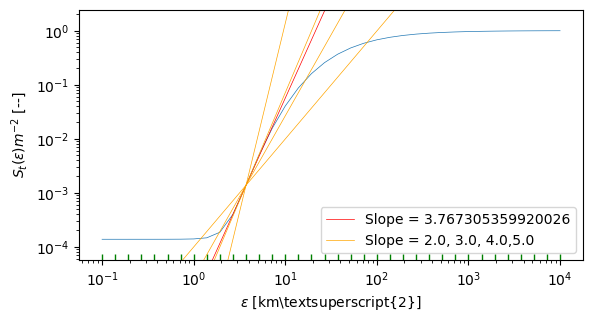

In [73]:
dd = ut.calc_dd(sums)
print(dd)
ut.plot_epsloglog(sums, dd["e_max"], dd["dimension"])

In [101]:
D = ut.calculate_distances(df.to_numpy(), 4) #  how to choose?
dist_mat = sps.csr_matrix((D[2], (D[0], D[1])),
                               shape=(df.shape[0], df.shape[0]))
dist_mat.trace()

np.float64(0.0)

In [83]:
diff_map = ut.calc_diff_map(dd["e_max"], 40, dist_mat)
diff_map[0]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99320747, 0.99319934, 0.9931988 ,
       0.99317487, 0.99315563, 0.99312632, 0.99305471, 0.99305453,
       0.99302835, 0.99301045, 0.99298739, 0.99298739, 0.99298705])

In [55]:
def plot_spectra(dist_mat, r, eps):
    '''
    Plots the EV spectra of each of the given epsilon to ax

    Parameters
    ----------
    r : array o floats
        cut-off radius.
    eps : array of floats
        diffusion bandwidth.
    X : array of floats
        x-coordinates.
    Y : array of floats
        y-coordinates.
    Z : array of floats
        z-coordinates.
    sc : float
        scaling parameter for the vertical.
    ax : Axes object
        the axes to plot to.
    bounds : boolean array
        indicates which points are boundary points.
    customMetric : boolean
        flag indicating whether to use a custom metric

    Returns
    -------
    None.

    '''
    from matplotlib.ticker import MaxNLocator, ScalarFormatter

    ax.cla()
    colors = plt.cm.viridis(np.linspace(0, 1, len(eps)))
    markers = ['o', 's', '^', 'v', '*']
    def format_scientific(value):
        """Custom function to format number in scientific notation without '+' sign."""
        return "${:.0e}$".format(value).replace('e+0', 'e').replace('e+', 'e')
    for i,e in enumerate(eps):
        print("epsilon = {}, r={}".format(e, r))
        # if alpha is to change according to the epsilon used
        # if bound_type=="spnalp":
        #     bounds, hulls = dd.io_bounds(
        #                 d_path + "stereop", "$\\alpha$", xcs, ycs, zcs,
        #                 alpha)

        vals, vecs = ut.calc_diff_map(e, 10, dist_mat)
        print(f"First eigenvalue = {vals[0]}")
        vals = (vals - 1)/e
        ax.scatter(x=np.arange(1, 11), y=np.real(vals)[:10],
                   label=format_scientific(e), zorder=5,
                   color=colors[i], marker=markers[i % len(markers)], s = 72)
        # Modify x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("$i$")

    # Modify y-axis
    ax.set_ylabel("$\lambda_i$")
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # Add grid
    ax.grid(True, which='both', linestyle="-", linewidth=0.5, zorder = 1)

    # Modify legend to be more compact
    legend = ax.legend(loc="lower left", bbox_to_anchor=(0.01, -0.01),
                       reverse=True,
                       ncols=3, frameon=False,
                       title="$\epsilon$ $[\mathrm{km}^2]$", borderpad=0.5,
                       labelspacing=0.25,
                       handletextpad=0.5, borderaxespad=0, columnspacing=0.8,
                       handleheight=0.1, handlelength=0.1, shadow=False)
    legend.get_title().set_ha('left')
    legend._legend_box.align = "left"

<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\e'
<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_79998/2277946196.py:58: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("$\lambda_i$")
/tmp/ipykernel_79998/2277946196.py:69: SyntaxWarning: invalid escape sequence '\e'
  title="$\epsilon$ $[\mathrm{km}^2]$", borderpad=0.5,


epsilon = 2, r=4
First eigenvalue = 1.0000000000000462
epsilon = 3, r=4
First eigenvalue = 1.0000000000000062
epsilon = 4, r=4
First eigenvalue = 1.0000000000000053
epsilon = 5, r=4
First eigenvalue = 1.0000000000000069
epsilon = 6, r=4
First eigenvalue = 1.0000000000000053


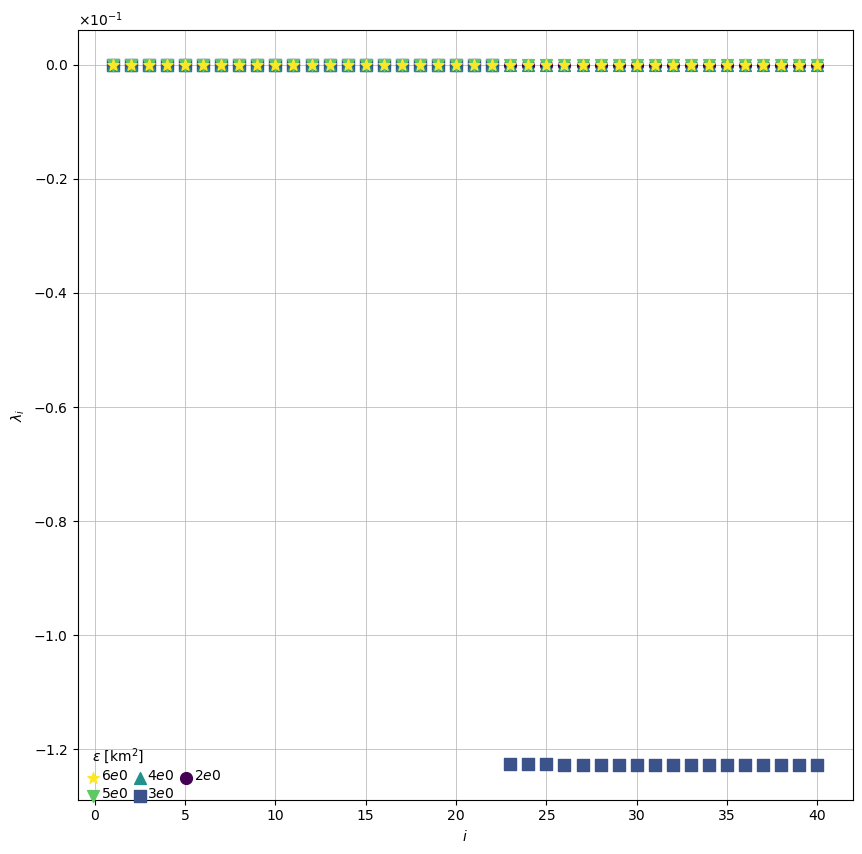

In [102]:
f,ax = plt.subplots(1,1,figsize=(10,10))
plot_spectra(dist_mat, 4, [2,3,4,5,6])

**gary froylands review to ftles: software available?**


# Proceed with Artificial Data since EOFs take time

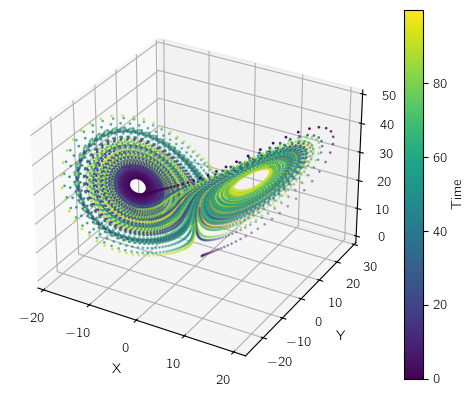

In [30]:
def Lorenz63(t, state, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """
    Computes the derivatives for the Lorenz 63 system at given state and time.

    Parameters:
    t (float): Current time.
    state (array-like): Current values of x, y, and z.
    sigma (float): Parameter, typically 10.
    rho (float): Parameter, typically 28.
    beta (float): Parameter, typically 8/3.

    Returns:
    list: Derivatives [dx/dt, dy/dt, dz/dt].
    """
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

def GenerateLorenzTimeSeries(initialState, tSpan, tStep, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """
    Generates a time series for the Lorenz 63 system.

    Parameters:
    initialState (array-like): Initial state [x0, y0, z0].
    tSpan (float): Total time duration for the simulation.
    tStep (float): Time step for output data.
    sigma (float): Parameter, typically 10.
    rho (float): Parameter, typically 28.
    beta (float): Parameter, typically 8/3.

    Returns:
    numpy.ndarray: Array of shape (N, 4) where N is the number of time steps;
                   columns represent time, x, y, and z values.
    """
    # Create time points for output
    tEval = np.arange(0, tSpan, tStep)
    
    # Solve the Lorenz system
    sol = solve_ivp(Lorenz63, (0, tSpan), initialState, args=(sigma, rho, beta),
                    t_eval=tEval, method='RK45')

    # Combine time and solution into a single array for easier handling
    result = np.column_stack((sol.t, sol.y.T))
    
    return result

# Example usage
initialState = [1.0, 1.0, 1.0]
tSpan = 100.0  # Total time
tStep = 0.01  # Time step
lorenzData = GenerateLorenzTimeSeries(initialState, tSpan, tStep)

# Plot the results
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# Use scatter to color by time
sc = ax.scatter(lorenzData[:, 1], lorenzData[:, 2], lorenzData[:, 3],
                c=lorenzData[:, 0], cmap=cm.viridis, marker='o', s=1)

# Add color bar for reference
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label='Time')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


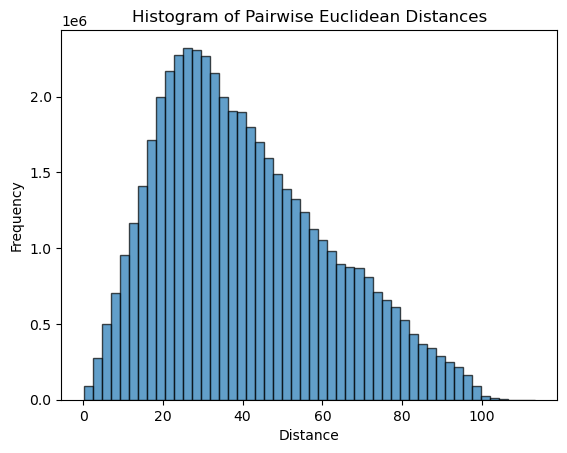

In [6]:
ut.plot_distance_histogram(lorenzData)

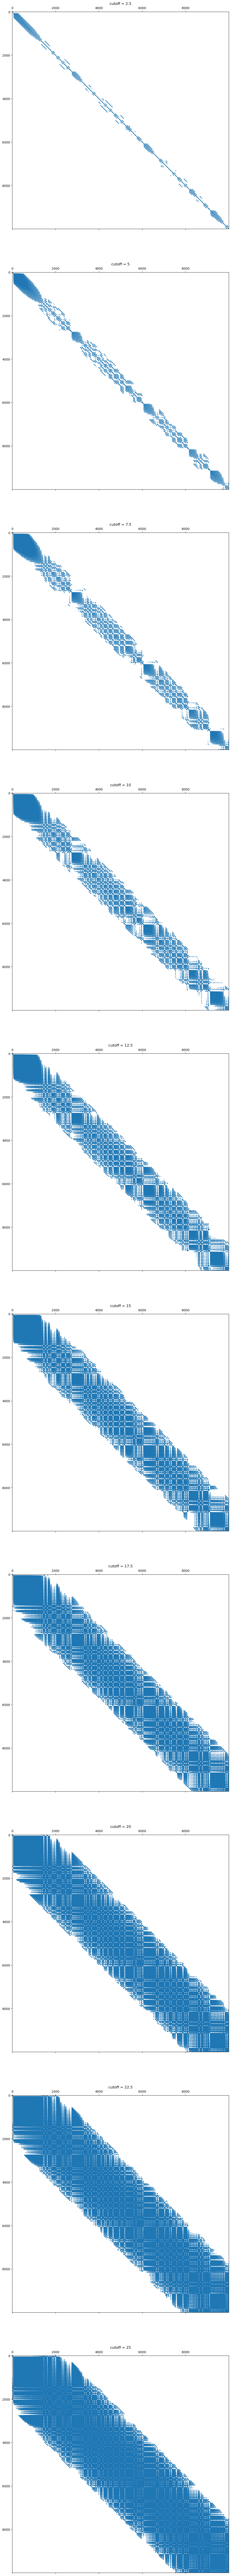

In [10]:
r_opt = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25]
fig, ax = plt.subplots(len(r_opt),1 ,figsize=(15, 15*len(r_opt)))

for i,r in enumerate(r_opt):
    D = ut.calculate_distances(lorenzData, r) #  how to choose?
    # Create a sparse matrix from the gathered row indices, column indices, and distances
    dist_mat = sps.csr_matrix((D[2], (D[0], D[1])),
                               shape=(lorenzData.shape[0], lorenzData.shape[0]))
    ax.flatten()[i].spy(dist_mat, markersize=.1)
    ax.flatten()[i].set_title("cutoff = {}".format(r))
    

In [24]:
sums = ut.calc_Sums(lorenzData, 1e6, np.logspace(-1, 4, num=46), "/net/scratch/schoelleh96/WP2/WP2.2a/data/lorenz", force_calc=True)

No. of dists: 
100000000
Avg. dist:
40.62573461139851
/net/scratch/schoelleh96/WP2/WP2.2a/data/lorenzrows.pkl
/net/scratch/schoelleh96/WP2/WP2.2a/data/lorenzcols.pkl
/net/scratch/schoelleh96/WP2/WP2.2a/data/lorenzdist.pkl
0.1
[0. 0. 0. ... 0. 0. 0.]
0.1291549665014884
[0. 0. 0. ... 0. 0. 0.]
0.16681005372000587
[0. 0. 0. ... 0. 0. 0.]
0.21544346900318834
[0. 0. 0. ... 0. 0. 0.]
0.2782559402207124
[0. 0. 0. ... 0. 0. 0.]
0.35938136638046275
[0. 0. 0. ... 0. 0. 0.]
0.46415888336127786
[0. 0. 0. ... 0. 0. 0.]
0.5994842503189409
[0. 0. 0. ... 0. 0. 0.]
0.774263682681127
[0. 0. 0. ... 0. 0. 0.]
1.0
[4.24032653e-315 0.00000000e+000 5.40268147e-315 ... 1.80710382e-312
 0.00000000e+000 0.00000000e+000]
1.291549665014884
[3.91482586e-244 3.87757655e-286 4.72250884e-244 ... 4.25308133e-242
 2.93856779e-263 4.99208417e-293]
1.6681005372000584
[3.45602718e-189 1.03821591e-221 3.99621573e-189 ... 1.30308043e-187
 5.38408536e-204 4.80170295e-227]
2.1544346900318834
[1.20549302e-146 7.94945009e-172 1

dimension     2.127534
density       0.072971
rho           0.155248
e_max        77.426368
L             1.075699
meandist     16.897581
dist         40.621672
dtype: float64


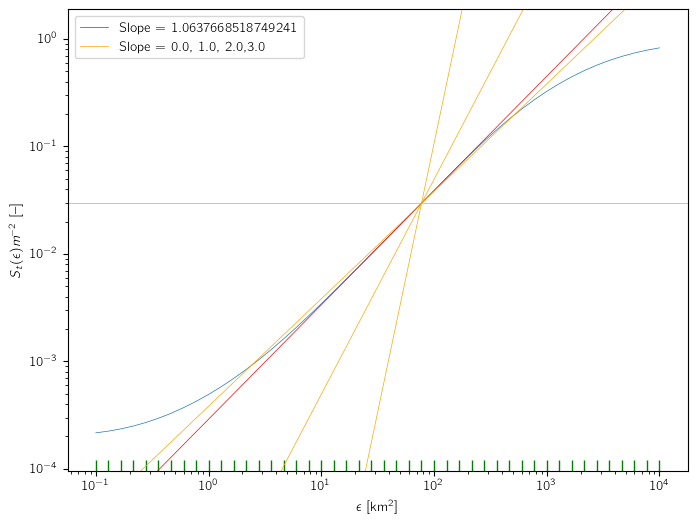

In [25]:
dd = ut.calc_dd(sums)
print(dd)
ut.plot_epsloglog(sums, dd["e_max"], dd["dimension"])

In [26]:
sums


eps      sums      m       dist
0       0.100000  0.000216  10000  40.621672
1       0.129155  0.000224  10000  40.621672
2       0.166810  0.000235  10000  40.621672
3       0.215443  0.000250  10000  40.621672
4       0.278256  0.000270  10000  40.621672
5       0.359381  0.000295  10000  40.621672
6       0.464159  0.000328  10000  40.621672
7       0.599484  0.000370  10000  40.621672
8       0.774264  0.000424  10000  40.621672
9       1.000000  0.000492  10000  40.621672
10      1.291550  0.000580  10000  40.621672
11      1.668101  0.000692  10000  40.621672
12      2.154435  0.000839  10000  40.621672
13      2.782559  0.001032  10000  40.621672
14      3.593814  0.001286  10000  40.621672
15      4.641589  0.001621  10000  40.621672
16      5.994843  0.002065  10000  40.621672
17      7.742637  0.002654  10000  40.621672
18     10.000000  0.003436  10000  40.621672
19     12.915497  0.004469  10000  40.621672
20     16.681005  0.005831  10000  40.621672
21     21.544347  0.007625  10000  40.621672
22     27.825594  0.009985  10000  40.621672
23     35.938137  0.013086  10000  40.621672
24     46.415888  0.017162  10000  40.621672
25     59.948425  0.022520  10000  40.621672
26     77.426368  0.029564  10000  40.621672
27    100.000000  0.038818  10000  40.621672
28    129.154967  0.050928  10000  40.621672
29    166.810054  0.066636  10000  40.621672
30    215.443469  0.086720  10000  40.621672
31    278.255940  0.111901  10000  40.621672
32    359.381366  0.142755  10000  40.621672
33    464.158883  0.179624  10000  40.621672
34    599.484250  0.222567  10000  40.621672
35    774.263683  0.271324  10000  40.621672
36   1000.000000  0.325305  10000  40.621672
37   1291.549665  0.383602  10000  40.621672
38   1668.100537  0.444990  10000  40.621672
39   2154.434690  0.507945  10000  40.621672
40   2782.559402  0.570711  10000  40.621672
41   3593.813664  0.631451  10000  40.621672
42   4641.588834  0.688471  10000  40.621672
43   5994.842503  0.740441  10000  40.621672
44   7742.636827  0.786523  10000  40.621672
45  10000.000000  0.826395  10000  40.621672

In [54]:
D = ut.calculate_distances(lorenzData, 20) #  how to choose?
    # Create a sparse matrix from the gathered row indices, column indices, and distances
dist_mat = sps.csr_matrix((D[2], (D[0], D[1])),
                          shape=(lorenzData.shape[0], lorenzData.shape[0]))

diff_map = ut.calc_diff_map(dd["e_max"], 10, dist_mat)
diff_map[0]

array([1.        , 0.99471814, 0.97969493, 0.97636091, 0.95143724,
       0.93565413, 0.92492526, 0.92309012, 0.89195598, 0.87292858])

epsilon = 7.74263682681127, r=20
First eigenvalue = 1.0000000000000038
epsilon = 24.484367468222267, r=20
First eigenvalue = 1.0000000000000038
epsilon = 77.4263682681127, r=20
First eigenvalue = 0.9999999999999973
epsilon = 244.84367468222268, r=20
First eigenvalue = 0.9999999999999996
epsilon = 774.263682681127, r=20
First eigenvalue = 1.0000000000000002


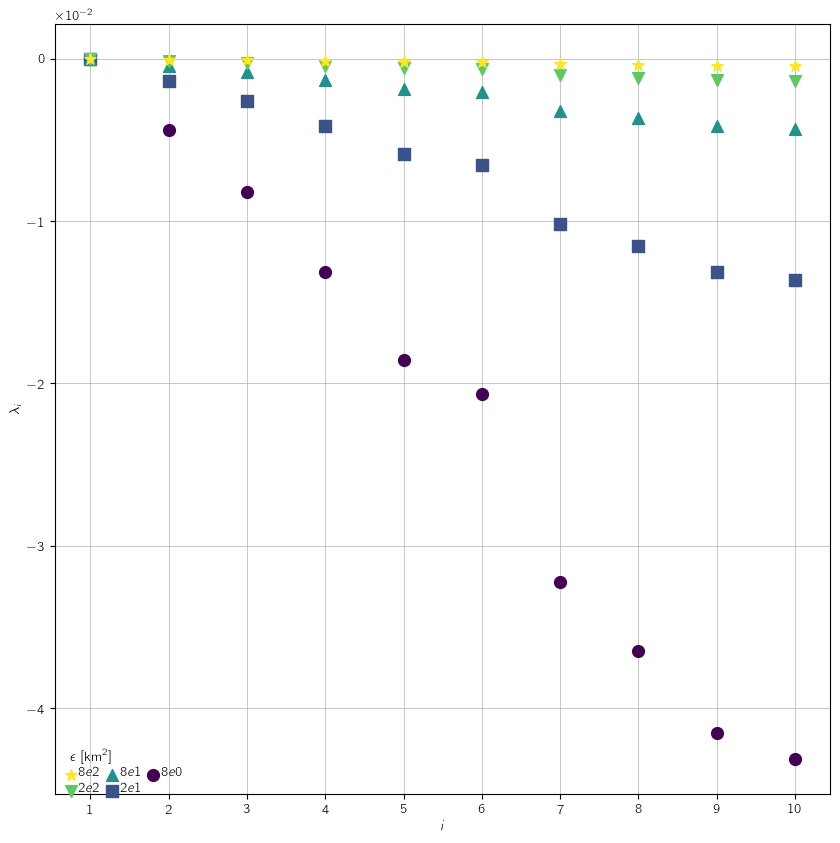

In [57]:
f,ax = plt.subplots(1,1,figsize=(5,5))
plot_spectra(dist_mat, 20, dd["e_max"]*np.logspace(-1, 1, num=5))

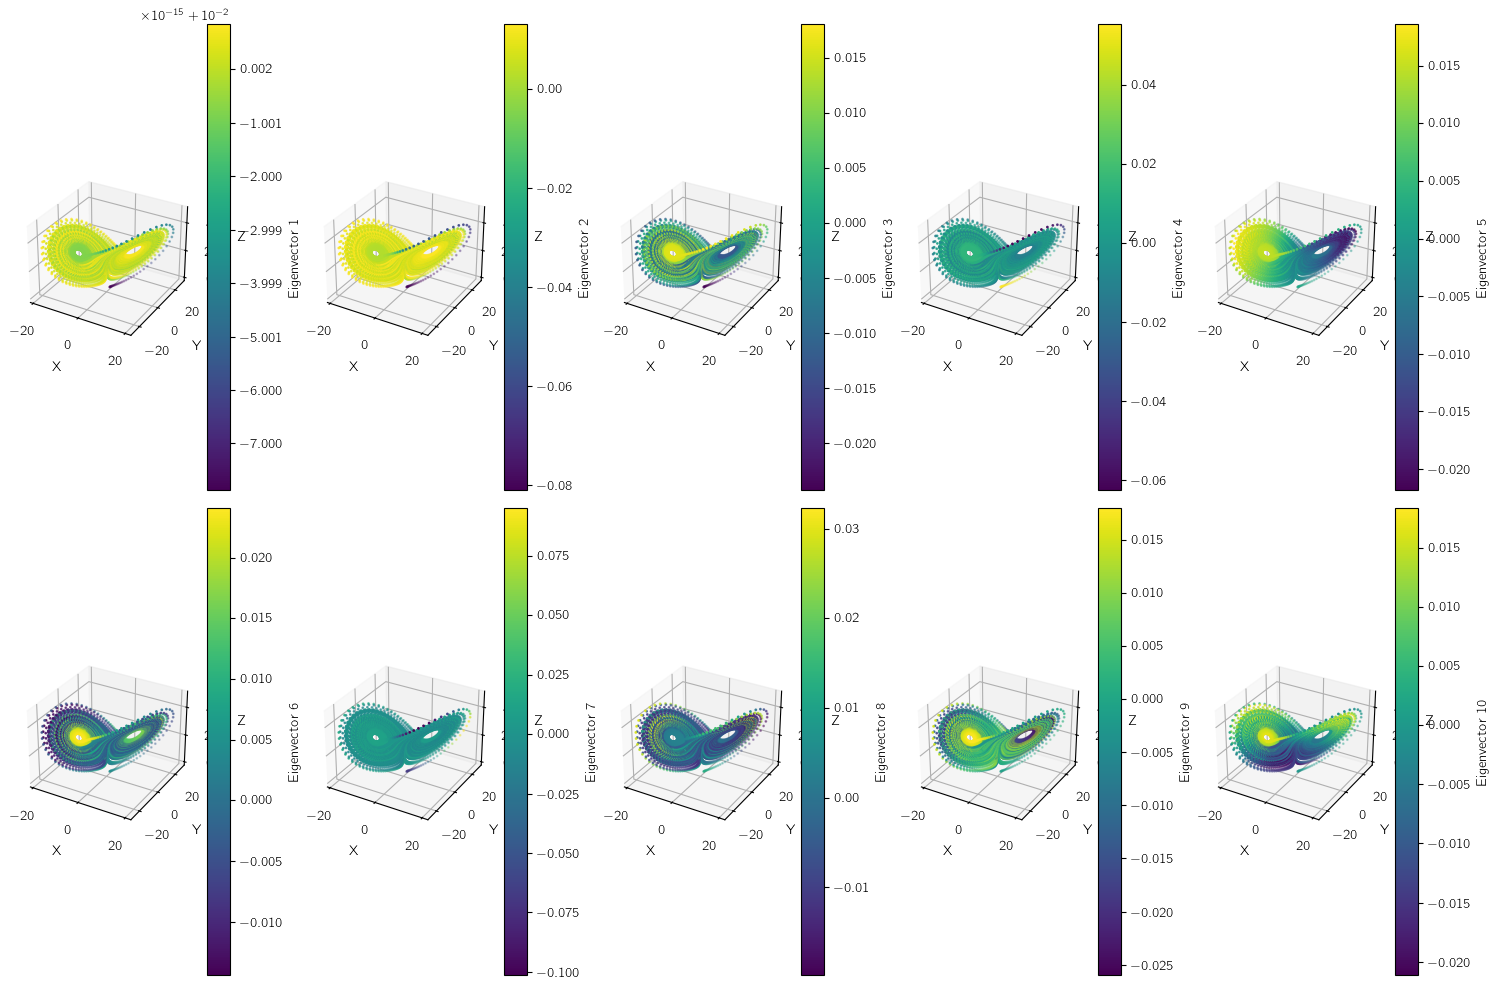

In [61]:
# Create a figure for subplots
fig = plt.figure(figsize=(15, 10))

# Loop through the 10 vectors and create a subplot for each
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, projection='3d')  # 2 rows, 5 columns
    # Normalize the color vector
    norm = plt.Normalize(diff_map[1][:, i].min(), diff_map[1][:, i].max())
    # Use scatter to color by the current vector
    sc = ax.scatter(lorenzData[:, 1], lorenzData[:, 2], lorenzData[:, 3],
                    c=diff_map[1][:, i], cmap=cm.viridis, marker='o', s=1, norm=norm)

    # Set labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Add color bar for reference
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label=f'Eigenvector {i + 1}')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [62]:
diff_map[1].shape

(10000, 10)

In [ ]:
def calculate_ftle(data, delta_t, time_interval):
    """
    Calculate FTLEs for a set of vectors in non-linear diffusion coordinates.

    Parameters:
    data (np.ndarray): Array representing the system.
    delta_t (int): Time step for FTLE calculation.
    time_interval (int): Interval to calculate FTLE.

    Returns:
    np.ndarray: FTLE values for each point in time.
    """
    n_t, n_coord = data.shape
    ftles = np.zeros((n_t - delta_t, n_coord))

    for i in range(n_coord):
        for t in range(n_t - delta_t):
            # Calculate distances at time t and t + delta_t
            d_t = np.linalg.norm(data[t + delta_t, i] - data[t, i])
            d_prev = np.linalg.norm(data[t, i])
            
            # Calculate FTLE
            if d_prev > 0:
                ftles[t, i] = (1 / delta_t) * np.log(d_t / d_prev)
            else:
                ftles[t, i] = np.nan  # Handle log(0) case

    return ftles